In [35]:
import os, re, requests, json
from io import StringIO
import pandas as pd
import numpy as np

%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# matplotlib colors
#https://matplotlib.org/stable/gallery/color/named_colors.html

data_path = "/home/gene/gblog/labor"
os.path.exists(data_path)

True

Title: 300 applications of unemployment

The headline stats suggest the employment market is buzzing with life. At 3.9%, unemployment is still historically low despite having increased from its post-pandemic trough. Similarly, yearly wage growth slowed to 3.9% yet but this is higher than anytime in the 10 years preceding the pandemic. In fact, overall private employment surpassed pre-pandemic levels by 5%. So why did I struggle or are the headline stats missing something?

# Fetch BLS Data via Their API

## Functions

Check Census API [here](https://www.bls.gov/developers/api_signature_v2.htm)

Check [signatures](https://www.bls.gov/developers/api_FAQs.htm#signatures5)

In [2]:
# function to fetch the json-data from the BLS website
def fetchjson(data_req, base_url='https://api.bls.gov/publicAPI/v2/timeseries/data/', headers={'Content-type':'application/json'}):
    res = requests.post(base_url, data=data_req, headers=headers)
    if 'SUCCEEDED' not in json.loads(res.text)['status']:
        print(res.text)
        return(None)
    if 'SUCCEEDED' in json.loads(res.text)['status']:   
        return(json.loads(res.text)['Results']['series'])
        

In [24]:
# function to process the results into dataframe
def api2json(res):
    dataDict = {}
    for i in res:
        # grab ID
        label = i['seriesID']
        # read the data
        dataDict[label] = pd.read_json(StringIO(json.dumps(i['data'])), orient='records')
        try:
            dataDict[label].columns = dataDict[label].columns.str.strip()
        
            # process dates
            dataDict[label].loc[:,'date'] = pd.to_datetime(dataDict[label].year.astype('str')+" "+dataDict[label].periodName, format = "%Y %B")
        
            # clean up by removing superfluous columns
            cols2drop = [x for x in ['footnotes','year','period','periodName','latest'] if x in dataDict[label].columns]
            dataDict[label].drop(cols2drop, axis=1, inplace=True)
            #dataDict[label].rename(columns = {'value':label},inplace=True)
            dataDict[label].set_index('date',inplace=True)
        except:
            print("\tSomething went wrong...here's what we have until it did")
            return(dataDict[label])
    # combine results
    outdf = pd.concat(dataDict,axis=1,keys=None).sort_index()
    outdf.columns = outdf.columns.droplevel(1)

    print("Earliest observation:", outdf.index.min().strftime("%Y-%m-%d"))
    print("Latest observation:",outdf.index.max().strftime("%Y-%m-%d"))
    print(outdf.tail())
    return(outdf)

## Fetch Series

Note, there seems to be an implicit limit on the length of the series that can be queries to about 9 years so to get the latest, I must start from 2015


The names of the tables can be found [here](https://www.bls.gov/help/hlpforma.htm#CE) but it isn't complete. Basically, just guess work

In [55]:
# make 9-year steps because BLS API limits data range to 9 years
step=9
yrsteps = list(np.arange(1990,2024,step))+[2024]
yrsteps

[1990, 1999, 2008, 2017, 2024]

In [ ]:
# save api key
api_key = "cafb8ba5322f47aa89c565af83064fad"

### Wages

In [4]:
### Wages
wages = ['CEU0500000003','CES0500000003']
unemployment = ["LNS1400000003","LNU1400000003"]

In [181]:
# container for data
datlist = []

for i in range(len(yrsteps)):
    if i<len(yrsteps)-1:
        print("Years: %d-%d" %(yrsteps[i],yrsteps[i+1]))
        data_req = json.dumps({"seriesid":wages,
                               'startyear':"%d" %yrsteps[i],
                               "endyear":"%d"%yrsteps[i+1],
                               'registrationkey':api_key})
        res = fetchjson(data_req)
        if res:
            datlist.append(api2json(res))

wag = pd.concat(datlist).sort_index()

Years: 1990-1999
Years: 1999-2008
Earliest observation: 2006-03-01
Latest observation: 2008-12-01
            CEU0500000003  CES0500000003
date                                    
2008-08-01          21.49          21.70
2008-09-01          21.68          21.72
2008-10-01          21.71          21.76
2008-11-01          21.96          21.87
2008-12-01          21.96          21.94
Years: 2008-2017
Earliest observation: 2008-01-01
Latest observation: 2017-12-01
            CEU0500000003  CES0500000003
date                                    
2017-08-01          26.17          26.38
2017-09-01          26.46          26.49
2017-10-01          26.62          26.49
2017-11-01          26.47          26.53
2017-12-01          26.58          26.61
Years: 2017-2024
Earliest observation: 2017-01-01
Latest observation: 2024-04-01
            CEU0500000003  CES0500000003
date                                    
2023-12-01          34.26          34.34
2024-01-01          34.67          34.51
20

In [202]:
# compute YoY wage growth
wagg = wag.CES0500000003.pct_change(12).dropna()
wagg.tail()

date
2023-12-01    0.042502
2024-01-01    0.043544
2024-02-01    0.042534
2024-03-01    0.041129
2024-04-01    0.039175
Name: CES0500000003, dtype: float64

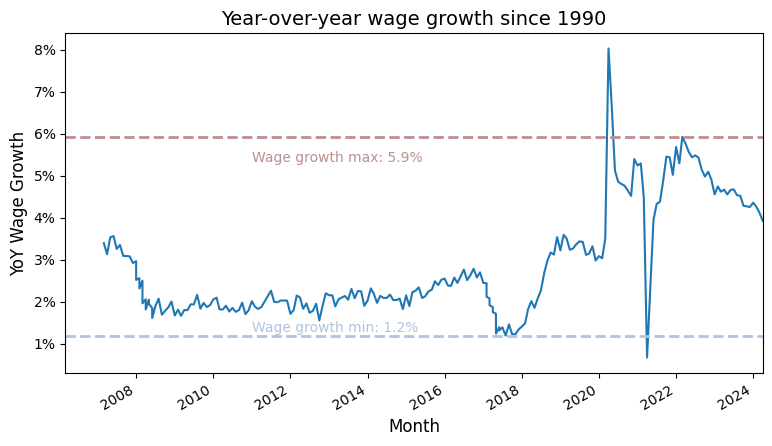

In [203]:
ax=wagg.plot(figsize = (9,5))
ax.set_xlim(wagg.min(), wagg.index.max())
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))


maxwagg = wagg.loc[(wagg<.06) & (wagg>.01)].max()
minwagg = wagg.loc[(wagg<.06) & (wagg>.01)].min()
plt.title("Wage growth")

ax.set_xlim(wag.index.min(), wag.index.max())
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

# annotations
## min and max
ax.annotate("Wage growth min: %.1f%%"%(100*minwagg), xy = ('2011-01-01',minwagg+.001),color='lightsteelblue')
ax.axhline(minwagg,linestyle='--', color='lightsteelblue', linewidth=2)


ax.axhline(maxwagg,linestyle='--', color='rosybrown', linewidth=2)
ax.annotate("Wage growth max: %.1f%%"%(100*maxwagg), xy = ('2011-01-01',maxwagg-.006),color='rosybrown')

#ax.axhline(wag.CES0500000003.pct_change(12).dropna().iloc[-1],linestyle='--', color='rosybrown', linewidth=2)
#ax.annotate("Wage growth max: %.1f%%"%(100*maxwagg), xy = ('2011-01-01',maxwagg-.006),color='rosybrown')


# title
ax.set_title("Year-over-year wage growth since 1990", fontsize = 14)
ax.set_ylabel("YoY Wage Growth", fontsize = 12)
ax.set_xlabel("Month", fontsize = 12)

plt.savefig("/".join([data_path, 'yoywagegrowth.png']), dpi=200, bbox_inches='tight', pad_inches=0.05)

### Unemployment

In [28]:
unemployment = ["LNS14000000"]

In [47]:
# initiate container for data list
datlist = []

for i in range(len(yrsteps)):
    if i<len(yrsteps)-1:
        print("Years: %d-%d" %(yrsteps[i],yrsteps[i+1]))
    
        data_req = json.dumps({"seriesid":unemployment,
                           'startyear':'%d'%yrsteps[i],#'startyear':"2015",
                           "endyear":'%d'%yrsteps[i+1],#"endyear":"2024",
                           'registrationkey':api_key})
        # fetch data
        res = fetchjson(data_req)
        if res:
            # process into dataframe
            datlist.append(api2json(res))

Years: 1990-1999
Earliest observation: 1990-01-01
Latest observation: 1999-12-01
            LNS14000000
date                   
1999-08-01          4.2
1999-09-01          4.2
1999-10-01          4.1
1999-11-01          4.1
1999-12-01          4.0
Years: 1999-2008
Earliest observation: 1999-01-01
Latest observation: 2008-12-01
            LNS14000000
date                   
2008-08-01          6.1
2008-09-01          6.1
2008-10-01          6.5
2008-11-01          6.8
2008-12-01          7.3
Years: 2008-2017
Earliest observation: 2008-01-01
Latest observation: 2017-12-01
            LNS14000000
date                   
2017-08-01          4.4
2017-09-01          4.3
2017-10-01          4.2
2017-11-01          4.2
2017-12-01          4.1
Years: 2017-2024
Earliest observation: 2017-01-01
Latest observation: 2024-04-01
            LNS14000000
date                   
2023-12-01          3.7
2024-01-01          3.7
2024-02-01          3.9
2024-03-01          3.8
2024-04-01          3.9


In [52]:
# combine fetched results and normalize to decimals since stats are percentages
emp = pd.concat(datlist).sort_index()/100

In [92]:
emp.head()

,LNS14000000
date,
1990-01-01,0.054
1990-02-01,0.053
1990-03-01,0.052
1990-04-01,0.054
1990-05-01,0.054


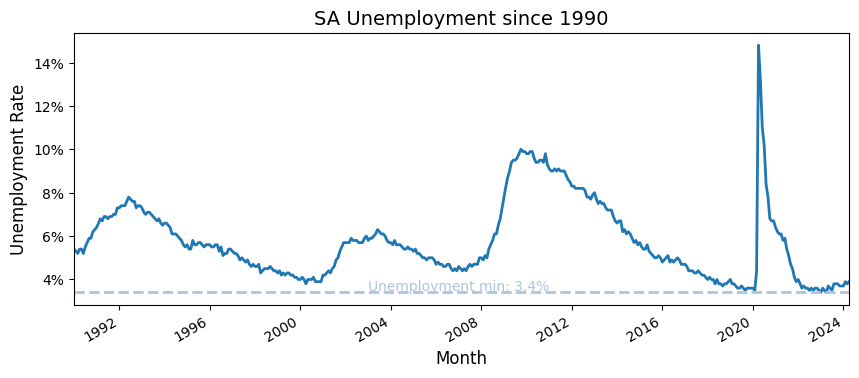

In [201]:
ax = emp.dropna().plot(figsize = (10,4), linewidth=2,legend=False)
ax.set_xlim(emp.index.min(), emp.index.max())
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

# annotations
## min and max
ax.annotate("Unemployment min: %.1f%%"%(100*emp.min().iloc[0]), xy = ('2003-01-01',emp.min().iloc[0]+.001),color='lightsteelblue')
ax.axhline(emp.min().iloc[0],linestyle='--', color='lightsteelblue', linewidth=2)


#ax.axhline(emp.max().iloc[0],linestyle='--', color='rosybrown', linewidth=2)
#ax.annotate("Unemployment max: %.1f%%"%(100*emp.iloc[1]), xy = ('2003-01-01',emp.max().iloc[0]-.006),color='rosybrown')


# title
ax.set_title("SA Unemployment since 1990", fontsize = 14)
ax.set_ylabel("Unemployment Rate", fontsize = 12)
ax.set_xlabel("Month", fontsize = 12)

plt.savefig("/".join([data_path, 'unemployment.png']), dpi=200, bbox_inches='tight', pad_inches=0.05)

# Number employed

In [224]:
nemp = ['CES0500000001']

In [225]:
# initiate container for data list
datlist = []

for i in range(len(yrsteps)):
    if i<len(yrsteps)-1:
        print("Years: %d-%d" %(yrsteps[i],yrsteps[i+1]))
    
        data_req = json.dumps({"seriesid":nemp,
                           'startyear':'%d'%yrsteps[i],#'startyear':"2015",
                           "endyear":'%d'%yrsteps[i+1],#"endyear":"2024",
                           'registrationkey':api_key})
        # fetch data
        res = fetchjson(data_req)
        if res:
            # process into dataframe
            datlist.append(api2json(res))
nemp=pd.concat(datlist)            

Years: 1990-1999
Earliest observation: 1990-01-01
Latest observation: 1999-12-01
            CES0500000001
date                     
1999-08-01         109194
1999-09-01         109377
1999-10-01         109722
1999-11-01         109971
1999-12-01         110241
Years: 1999-2008
Earliest observation: 1999-01-01
Latest observation: 2008-12-01
            CES0500000001
date                     
2008-08-01         114642
2008-09-01         114222
2008-10-01         113745
2008-11-01         112986
2008-12-01         112292
Years: 2008-2017
Earliest observation: 2008-01-01
Latest observation: 2017-12-01
            CES0500000001
date                     
2017-08-01         124597
2017-09-01         124666
2017-10-01         124785
2017-11-01         124996
2017-12-01         125137
Years: 2017-2024
Earliest observation: 2017-01-01
Latest observation: 2024-04-01
            CES0500000001
date                     
2023-12-01         134228
2024-01-01         134424
2024-02-01         134605


In [226]:
# extract month from date
nemp.loc[:,'month'] = nemp.index.month

In [228]:
# merge in 2019 values
nemp.loc[:,'nemp2019'] = nemp.merge(nemp.loc[(nemp.index.year==2019), :], on='month', suffixes=['','_19']).CES0500000001_19.values

In [229]:
# normalize values by 2019 ones
nemp.loc[:,'relative2019'] = nemp.CES0500000001/nemp.nemp2019

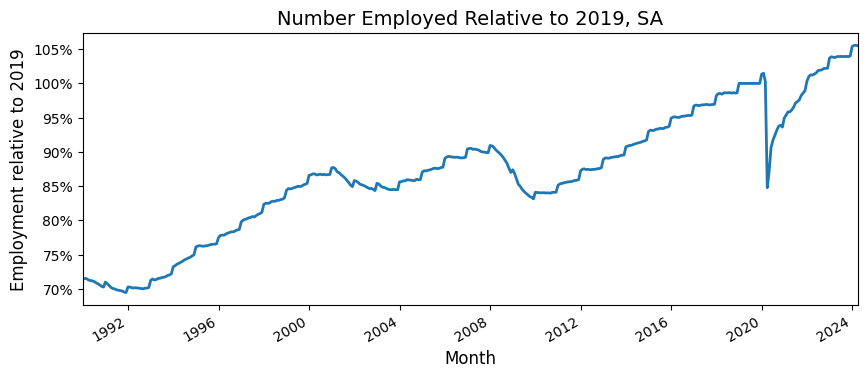

In [234]:
ax = nemp.relative2019.dropna().sort_index().plot(figsize = (10,4), linewidth=2,legend=False)
ax.set_xlim(emp.index.min(), emp.index.max())
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

# annotations
## min and max
#ax.annotate("Unemployment min: %.1f%%"%(100*emp.min().iloc[0]), xy = ('2003-01-01',emp.min().iloc[0]+.001),color='lightsteelblue')
#ax.axhline(emp.min().iloc[0],linestyle='--', color='lightsteelblue', linewidth=2)


#ax.axhline(emp.max().iloc[0],linestyle='--', color='rosybrown', linewidth=2)
#ax.annotate("Unemployment max: %.1f%%"%(100*emp.iloc[1]), xy = ('2003-01-01',emp.max().iloc[0]-.006),color='rosybrown')


# title
ax.set_title("Number Employed Relative to 2019, SA", fontsize = 14)
ax.set_ylabel("Employment relative to 2019", fontsize = 12)
ax.set_xlabel("Month", fontsize = 12)

plt.savefig("/".join([data_path, 'numberemployed.png']), dpi=200, bbox_inches='tight', pad_inches=0.05)